In [1]:
from rouge_score import rouge_scorer
import llm2geneset
import json
import openai
import numpy as np
import random
import pandas as pd

aclient = openai.AsyncClient()

# ROUGE metric example

In [2]:
#rouge1 : unigram
#rouge2 : bigram
#rougeL : longest common subsequence 
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [3]:
scores

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765),
 'rouge2': Score(precision=0.2857142857142857, recall=0.25, fmeasure=0.26666666666666666),
 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}

# Test 

In [4]:
lib_names = ["KEGG_2021_Human", 
             "Reactome_2022", 
             "WikiPathway_2023_Human"]

In [5]:
model = "gpt-4o-2024-05-13"

df_output=pd.DataFrame()

for lib_name in lib_names:
    with open("libs_human/" + model + "/" + lib_name + ".json") as f:
        gen_res = json.load(f)
        descr_cleaned = gen_res['descr_cleaned']
        curated_genesets = gen_res["curated_genesets"]
        lib_size = len(descr_cleaned)

        for i in range(10):
            # randomly choose 2 gene sets from library
            rand_choices = random.sample(range(lib_size), 2)
            gt_name = [descr_cleaned[rand_choices[0]], descr_cleaned[rand_choices[1]]]
            # combine and shuffle the genes from 2 gene sets
            genes = [curated_genesets[rand_choices[0]], curated_genesets[rand_choices[1]]]
            genes_combine = set()
            for g in genes:
                genes_combine.update(set(g))  
            genes_combine = list(genes_combine)
            random.shuffle(genes_combine)
            genes_queries = [[", ".join(genes_combine)]]
            
            # use llm2geneset to generate high confidence gene set names
            llm2geneset_res = await llm2geneset.get_pathways_from_genes(aclient, 
                                                                        genes_queries, 
                                                                        model="gpt-4o", 
                                                                        n_retry=3, 
                                                                        use_sysmsg=False)
            llm2geneset_names = np.array(llm2geneset_res[0]['parsed_pathways'])[np.array(llm2geneset_res[0]['conf'])=='high']
    
            # use GSAI to generate geneset name
            gsai_res = await llm2geneset.gsai(aclient, genes_queries, model="gpt-4o", n_retry=1)
            gsai_name = gsai_res[0]['name']
    
            gsai_scores=[]
            llm2geneset_scores=[]

            for ref in gt_name:
                gsai_scores.append(scorer.score(ref, gsai_name)['rouge1'].fmeasure)
                scores = []
                for pred in llm2geneset_names:
                    scores.append(scorer.score(ref, pred)['rouge1'].fmeasure)
                llm2geneset_scores.append(np.max(scores))

            output={"library":[lib_name],
                    "gt_name_1":[gt_name[0]],
                    "gt_name_2":[gt_name[1]],
                    "gsai_ROUGE1_1":[gsai_scores[0]],
                    "gsai_ROUGE1_2":[gsai_scores[1]],
                    "llm2geneset_ROUGE1_1":[llm2geneset_scores[0]],
                    "llm2geneset_ROUGE1_2":[llm2geneset_scores[1]]} 
            df_output = pd.concat([df_output, pd.DataFrame(output)], ignore_index=True)

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.40s/it]


Name: Signal Transduction and Transcriptional Regulation
LLM self-assessed confidence: 0.85

Critical Analysis:

1. Signal Transduction: This protein system includes numerous components involved in signal transduction. For instance, the presence of multiple G proteins (e.g., GNG, GNA subunits), MAP kinases (e.g., MAPK1, MAPK3, MAPK10), and adenylate cyclases (ADCY subunits) highlights intricate signaling networks. These proteins play pivotal roles in transducing extracellular signals into intracellular responses. Such pathways often commence with a receptor-ligand interaction leading to G protein activation, subsequent modulation of adenylate cyclase or phospholipase pathways (as indicated by PLCB2, PLCB3, PLCB4), and eventual phosphorylation cascades involving MAP kinases and AKT.

2. Transcriptional Regulation: Several transcription factors and transcription-associated proteins (e.g., CREB1, CREB3L1, TBP, TAFs, GTFs) are prominent in this system, emphasizing the regulation of gene ex

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.96s/it]


Name: Signal Transduction and Xenobiotic Metabolism Interaction Network
LLM self-assessed confidence: 0.89

The provided protein system prominently features proteins involved in signal transduction pathways and xenobiotic metabolism. The key interacting components can be categorized into several critical groups:

1. **Receptor Tyrosine Kinases and Associated Signaling Pathways**: Proteins such as ALK, MET, ERBB2, and EGFR are receptor tyrosine kinases that play vital roles in cell signaling. These receptors activate downstream signaling cascades critical for cell growth, differentiation, and survival. For example, MET can activate the MAPK and PI3K pathways, essential for signal transduction. Additionally, linker proteins like GRB2 and SOS1/SOS2 act as adaptors in these pathways.

2. **PI3K/AKT/mTOR Pathway**: The PI3K/AKT pathway is represented comprehensively, with several catalytic subunits (PIK3CA, PIK3CB, PIK3CD) and regulatory subunits (PIK3R1, PIK3R2, PIK3R3) of phosphoinositide

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.07s/it]


Name: Immune System Regulation and Signal Transduction
LLM self-assessed confidence: 0.90

This system of proteins primarily involves components critical to immune cell function, signal transduction, and ion transport processes. These proteins fall into several interconnected clusters based on their primary roles and interactions.

1. **T-cell and B-cell Activation and Signaling:**
   - **CD3E, CD4, CD8A/B, CD19, CD40, CD40LG, ZAP70, ICOS, PRKCA/B/G, JAK3:** These proteins are involved in the activation, differentiation, and signal transduction in T-cells and B-cells, essential for adaptive immune responses. CD proteins, ZAP70, and JAK3 are crucial in T-cell receptor signaling, while CD19, CD40, and CD40LG are pivotal in B-cell receptor signaling and interactions.

2. **Cytokine Signaling and Regulation:**
   - **IL7R, IL2RG:** These receptors are part of the cytokine receptor family crucial for lymphocyte development and function. The interaction of these receptors with JAK3 further e

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.98s/it]


Name: Immune Response Regulation and Signal Transduction
LLM self-assessed confidence: 0.95

The system of interacting proteins given consists mostly of components critical for immune response regulation, signal transduction pathways, and cellular responses to external stimuli. Here's a breakdown of the key roles these proteins play and their interplay:

1. **Cytokine Signaling and JAK-STAT Pathway**: Proteins such as JAK1, JAK2, IFNGR1, IFNGR2, and STAT proteins (STAT1, STAT3) play central roles in cytokine signaling, with JAK-STAT pathways being critical for mediating responses to various cytokines, including interferons (e.g., IFNG). These pathways regulate gene expression related to immune responses, cell survival, and proliferation.

2. **T-cell Receptor Signaling**: T-cell surface proteins like CD3G, CD3E, CD3D, CD4, and CD28 are crucial for T-cell receptor (TCR) signaling. This signaling is essential for T-cell activation and differentiation, involving kinases such as ZAP70, LCK

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/it]


**Name: Regulation of Cell Growth, Apoptosis, and Signaling via TGF-beta Pathway**

**LLM self-assessed confidence: 0.86**

1. **TGF-beta Signaling:** TGFB1, TGFB2, and TGFB3 are prominent members of the Transforming Growth Factor-Beta (TGF-beta) family, critical for cellular growth, differentiation, and apoptosis. TGFBR1 and TGFBR2 are their receptors that initiate the downstream signaling cascade. SMAD4, a central mediator in the TGF-beta pathway, interacts with receptor-regulated SMADs to transduce the signal to the nucleus, affecting gene expression.

2. **Cell Cycle Regulation and Apoptosis:** Proteins such as TP53, CDKN1A, CDKN1B, CDKN2A, and RB1 are central to cell cycle regulation and apoptosis. TP53, known as the "guardian of the genome," regulates cell cycle arrest and apoptosis in response to DNA damage. The cyclin-dependent kinase inhibitors CDKN1A (p21), CDKN1B (p27), and CDKN2A (p16) inhibit cell cycle progression, preventing unregulated cell growth. BCL2L1, BAD, BAX, and

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.07s/it]


Name: Olfactory signal transduction and mitochondrial bioenergetics
LLM self-assessed confidence: 0.85

The system of interacting proteins provided encompasses two major biological processes: olfactory signal transduction and mitochondrial bioenergetics. 

1. **Olfactory Signal Transduction:**
   A significant portion of the proteins in this system are olfactory receptors (ORs), which include OR52B6, OR5D14, OR1Q1, and many others. These receptors are critical for the detection of odor molecules and play a substantial role in the initiation of olfactory signal transduction. Upon ligand binding, these receptors activate downstream G-proteins such as GNAQ and GNG13. These G-proteins then modulate the activity of various intracellular effectors, including adenylate cyclases like ADCY3, which catalyze the production of cyclic AMP (cAMP) from ATP. The rise in cAMP levels activates cyclic nucleotide-gated ion channels (such as CNGA2 and CNGA4), leading to an influx of ions and generation of 

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Name: Pancreatic differentiation and function
LLM self-assessed confidence: 0.95

1. **Transcription Factors**:
   - **PDX1, RFX6, NEUROG3, ONECUT1, MAFA, HNF4A, BHLHA15, PAX4, NR5A2, HNF1A, NEUROD1, HNF1B, PAX6, HHEX, NKX6-1, MNX1, FOXA2, NKX2-2**: These transcription factors play crucial roles in the development, differentiation, and maturation of pancreatic tissues, particularly pancreatic beta cells. For instance, PDX1 and NKX6-1 are essential for beta-cell maturation and function, while NEUROG3 is vital for endocrine cell specification.

2. **Hormones and Secretory Proteins**:
   - **INS (Insulin)** and **IAPP (Islet Amyloid Polypeptide)**: Both of these are critical for glucose homeostasis. Insulin manages blood glucose levels by promoting cellular glucose uptake, whereas IAPP regulates the action of insulin and plays a role in beta-cell health and amyloid formation in diabetes.

3. **Metabolic Enzymes**:
   - **GCK (Glucokinase), PKLR (Pyruvate Kinase), XDH (Xanthine Dehydrogena

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Name: DNA Repair Mechanisms and Glycosylation Pathways
LLM self-assessed confidence: 0.89

1. **DNA Repair Mechanisms**: A significant subset of the proteins, including POLD1, POLB, XRCC1, OGG1, SMUG1, UNG, NEIL3, NEIL2, POLL, POLH, NEIL1, POLD2, POLD4, POLE, POLE2, POLE3, POLE4, and APEX1, are directly involved in various DNA repair pathways. For example, POLD1 (DNA polymerase delta catalytic subunit) and POLE (DNA polymerase epsilon catalytic subunit) are involved in DNA synthesis and repair. XRCC1 interacts with DNA ligase III (LIG3) and DNA polymerase β (POLB) in the base excision repair (BER) pathway. Proteins such as OGG1 and UNG are essential for glycosylase activities that initiate BER by recognizing and removing damaged bases.

2. **Glycosylation Pathways**: Another important group of proteins involves enzymes essential for glycosylation, such as MGAT2, MGAT1, MGAT4A, MGAT4B, MGAT4C, MGAT4D, MAN1A1, MAN1A2, MAN1C1, MAN2A1, MAN2A2, ALG1, ALG2, ALG3, ALG9, ALG12, ALG13, and ALG1

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.38s/it]


Name: Signal Transduction and Cellular Proliferation
LLM self-assessed confidence: 0.90

The system of interacting proteins provided includes a large number of proteins associated with signal transduction pathways and cellular proliferation. Below is a critical analysis of the major groups of proteins and their functional integration within the system:

1. **Growth Factors and Receptors:** 
   - **Fibroblast Growth Factors (FGFs)** and **FGF Receptors (FGFRs):** FGF1, FGF2, FGF4, FGF5, FGF6, FGF7, FGF9, FGF10, FGF16, FGF17, FGF18, FGF19, FGF20, FGF21, FGF22, and their respective receptors (e.g., FGFR2). FGFs play a crucial role in cell proliferation, differentiation, and angiogenesis by activating FGFR-mediated signaling cascades.
   - **Transforming Growth Factors (TGFs):** TGFB1, TGFB2, TGFB3, TGFBR1, and TGFBR2. These proteins regulate cell growth, differentiation, and apoptosis, often interacting with the SMAD pathway.
   - **Platelet-Derived Growth Factors (PDGFs) and their recept

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.35s/it]


Name: Cytokine and Growth Factor Signaling
LLM self-assessed confidence: 0.95

1. The system comprises numerous cytokines including interleukins (IL-1, IL-4, IL-6, IL-17, IL-22, IL-27), interferons (IFNA, IFNB, IFNL), and growth factors (GDF, BMP), indicating a prominent role in immune response and cellular growth regulation. Cytokines are crucial for mediating immune system communication and controlling inflammation, differentiation, and proliferation.

2. Tumor necrosis factor receptors (TNFRSF) and their ligands (TNF, TNFSF) suggest involvement in apoptotic signaling and immune system modulation. These proteins are key to inducing cell death and regulating immune cell activation.

3. The presence of growth hormone receptor (GHR) and prolactin receptor (PRLR) proteins indicates their role in mediating growth hormone and prolactin signaling, critical for growth, metabolism, and reproductive functions.

4. Signaling pathways are further indicated by proteins involved in downstream effe

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.39s/it]


Name: IL-17 signaling and MAPK pathway regulation
LLM self-assessed confidence: 0.92

The proteins in this system exhibit strong functional associations predominantly with the IL-17 signaling pathway and various branches of the MAPK signaling pathway. Here are the key points of analysis:

1. **IL-17 Signaling Pathway**:
   - **IL17RB, IL17RC, IL17RE, IL17RA, IL25, IL17C, IL17F**: These interleukin receptors and cytokines are central to the IL-17 signaling pathway, crucial for mediating inflammatory responses. IL-17 cytokines bind to their corresponding receptors, activating downstream signaling cascades.
   - **TRAF6, NOD1, NOD2, RIPK2, IRAK1, IRAK2**: Important signaling molecules within the IL-17 pathway. NOD1/2 and TRAF6 facilitate immune responses, while RIPK2 and IRAK1/2 are involved in signal transduction.
   - **TAB1, TAB2, TAB3**: These adapter proteins collaborate with TAK1 to mediate signaling in response to IL-17 stimulation.

2. **MAPK Signaling Pathways**:
   - **MAP2K3, M

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.86s/it]


Name: Microtubule Dynamics and Cytoskeletal Organization
LLM self-assessed confidence: 0.95

1. The largest proportion of proteins in the system are tubulins (TUBA1A, TUBA1B, TUBA1C, TUBA3D, TUBA3C, TUBA4A, TUBA4B, TUBA8, TUBB, TUBB2A, TUBB2B, TUBB3, TUBB4A, TUBB4B, TUBB6, TUBB8, TUBB8B). Tubulins are structural proteins that polymerize to form microtubules, which are key components of the cytoskeleton. Microtubules are involved in maintaining cell shape, enabling intracellular transport, and facilitating cell division by forming the mitotic spindle.

2. LIMK1 (LIM domain kinase 1) and PKN1/PKN2 (Protein Kinase N1/N2) are involved in regulating cytoskeletal dynamics. LIMK1 plays a key role in actin cytoskeleton remodeling by phosphorylating and inactivating cofilin. PKN proteins influence microtubule organization and stabilization, and are linked to signaling pathways that mediate cytoskeletal reorganization.

3. Proteins from the Charged Multivesicular Body Protein (CHMP) family (CHMP

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.28s/it]


Name: Autophagy and Ion Transport
LLM self-assessed confidence: 0.80

1. **Autophagy-Related Proteins**: Several proteins in this system, such as ATG5, ATG12, ULK1, MAP1LC3A, MAP1LC3B, PGAM5, and FUNDC1, are key components and regulators of the autophagy pathway. ATG5 and ATG12 form a complex crucial for autophagosome formation. ULK1 is a serine/threonine kinase that initiates autophagy in response to nutrient deprivation. MAP1LC3A and MAP1LC3B are essential for membrane expansion and closure during autophagosome biogenesis. FUNDC1 mediates mitophagy, which is important for selective degradation of damaged mitochondria. PGAM5 interacts with FUNDC1 and regulates mitochondrial quality control processes.

2. **Ion Transport Proteins**: The SCNN1 family (SCNN1A, SCNN1B, SCNN1G, and SCNN1D) encodes subunits of the epithelial sodium channel (ENaC), which is responsible for sodium reabsorption in epithelial tissues, affecting fluid balance and blood pressure regulation. CALHM1 and CALHM3 are 

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.55s/it]


Name: Notch Signaling Pathway and Epigenetic Modulation
LLM self-assessed confidence: 0.92

This system of interacting proteins primarily revolves around the Notch signaling pathway, which plays an essential role in cell fate determination and differentiation across various tissues. The key components and modulators of this pathway include:

1. **Notch receptors and ligands**: NOTCH1, DLL1, DLL4, JAG1, and JAG2 are pivotal in initiating the signaling cascade. These interactions are critical for the receptor-ligand binding process that triggers the subsequent intracellular signaling events.

2. **Gamma-secretase complex**: Major components like PSEN1, PSEN2, APH1A, APH1B, and PSENEN are involved in the proteolytic cleavage of Notch receptors, essential for releasing the Notch intracellular domain (NICD) and transactivating target genes.

3. **Transcriptional regulatory proteins**: RBPJ (CBF1), MAML1, MAML2, MAML3, and other co-activators such as EP300 and CREBBP mediate the transcriptio

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.21s/it]


Name: Epidermal Growth Factor Receptor (EGFR) Signaling and Glycosylation 
LLM self-assessed confidence: 0.91

1. **EGFR and its Ligands**: EGFR is a tyrosine kinase receptor that, upon activation by its ligands (e.g., TGFA, EREG, AREG, EGF, BTC, HBEGF), initiates several intracellular downstream signaling cascades. This signaling modulates cellular processes such as proliferation, differentiation, and survival. EGFR activation engages several downstream pathways, such as the PI3K/AKT pathway (PIK3CA, PIK3R1) and SRC kinase pathways.

2. **PI3K/AKT Pathway**: The PI3K/AKT signaling pathway is crucial in promoting cell survival and growth in response to extracellular signals. PIK3CA and PIK3R1 are essential components of this pathway and function downstream of EGFR to promote cellular proliferation and prevent apoptosis. This pathway's role is critical in oncogenesis and cancer maintenance.

3. **Adaptor and Signaling Proteins**: Proteins like GRB2 and PTPN11 serve as adaptors that brid

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.21s/it]


**Name:** Fibroblast Growth Factor Signaling and Sulfur Metabolism  
**LLM self-assessed confidence:** 0.87

Fibroblast growth factor (FGF) signaling:  
1. **FGFR1, FGFR3, FRS2, FRS3, GRB2, HRAS, NRAS, SOS1, PTPN11**: These proteins are integral to the FGF signaling pathway. FGFRs (Fibroblast Growth Factor Receptors) bind FGFs (e.g. FGF1, FGF4, FGF6, FGF8, FGF9, FGF10, FGF13, FGF17, FGF20, FGF22, FGF23), leading to receptor dimerization and activation. This stimulates downstream signaling proteins like FRS2/3, GRB2, and SOS1, which further activate RAS proteins (HRAS, NRAS) and ultimately lead to cellular responses such as differentiation, proliferation, and migration.

2. FGF proteins: Various FGFs (FGF1, FGF4, FGF6, FGF8, FGF9, FGF10, FGF13, FGF17, FGF20, FGF22, FGF23) are involved in various developmental and physiological processes. These include angiogenesis, wound healing, limb and organ development, and metabolic regulation.

Sulfur metabolism-related proteins:  
1. **SQOR, MPST

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.03s/it]


Name: Transcription Regulation and Chromatin Remodeling
LLM self-assessed confidence: 0.85

1. **Core Transcription Machinery & Regulation**: Several proteins listed, such as POLR2A, POLR2B, POLR2C, POLR2D, POLR2E, POLR2F, POLR2G, POLR2H, POLR2I, POLR2J, and POLR2L are subunits of RNA polymerase II, which is crucial for the transcription of DNA into mRNA. Additionally, transcription factors and general transcription factors (e.g., GTF2H1, GTF2H2, GTF2H3, GTF2H4, GTF2H5, GTF2E1, GTF2E2, GTF2B, GTF2A1, GTF2A2, TBP, TAF1, TAF2, TAF3, TAF4, TAF5, TAF6, TAF7, TAF9, TAF10, TAF11, TAF12, TAF13, TAF15, TAF7L, TAF9B, TAF1L) indicate a significant role in the regulation of gene expression.

2. **Chromatin Remodeling and Histone Modification**: Proteins such as H2AC7, H2BC13, H2AX, H1-0, H1-3, H2BC5, H2BC12L, H2AR1, H2AZ1, H2AC19, H2BC21, and H4C15 represent various histones and histone variants. Combined with chromatin remodelers like EP400 and HMGA1/2, they facilitate the remodeling of chromati

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.05s/it]


Name: Interferon-mediated antiviral response
LLM self-assessed confidence: 0.98

This collection of proteins is prominently involved in the interferon-mediated antiviral response, which is crucial for the defense against viral infections. Interferons are cytokines that play key roles in the activation of both innate and adaptive immune responses. Several components of the system, including IFNA5, IFNA7, IFNA21, IFNA6, IFNB1, and various other IFN-α (interferon-alpha) subtypes, directly represent type I interferons, which are pivotal for initiating these responses.

1. **Interferon Regulatory Factors (IRFs)**: IRF7, IRF9, IRF3, IRF1, IRF5, IRF4, IRF2, IRF6, and IRF8 are crucial transcription factors involved in the regulation of interferon genes, thus amplifying the immune response against viral pathogens. IRF3 and IRF7 are directly activated by viral infections and translocate to the nucleus, where they initiate the transcription of interferon genes.

2. **Signal Transduction (TYK2, JA

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.14s/it]


Name: Proteasome-mediated protein degradation and regulatory function
LLM self-assessed confidence: 0.99

The predominant biological process performed by this system of interacting proteins is proteasome-mediated protein degradation, coupled with regulation by associated factors. The identified proteins are heavily involved in the formation and function of the proteasome complex, as well as its regulatory components. This system includes:

1. **Proteasome subunits**: Multiple proteasomal proteins (e.g., PSMA1-PSMA8, PSMB1-PSMB11, PSMD1-PSMD14, PSMC1-PSMC6) make up the core 20S proteasome and the regulatory 19S complexes. These subunits constitute the machinery responsible for protein degradation, playing essential roles in maintaining protein homeostasis by degrading ubiquitinated proteins.

2. **Proteasome regulators and ubiquitin-related factors**: UBA52, UBB, and UBC are involved in ubiquitin-mediated processes, tagging proteins for degradation by the proteasome. PSMF1 acts as a pro

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.68s/it]


Name: Mitochondrial energy metabolism and redox homeostasis
LLM self-assessed confidence: 0.88

The given set of interacting proteins appears to be predominantly involved in processes associated with mitochondrial energy metabolism and redox homeostasis. Here is a critical analysis of the biological processes performed by this system of interacting proteins:

1. **Mitochondrial Oxidative Phosphorylation and Energy Production**: Several proteins in the set are crucial components of the mitochondrial oxidative phosphorylation (OXPHOS) system. The cytochrome c oxidase (COX) subunits, including COX5A, COX5B, COX6A1, COX6B1, COX6C, COX7A2L, COX7B, COX7C, COX8A, COX14, COX19, and COX20, play pivotal roles in electron transfer and the terminal step of the mitochondrial respiratory chain. These proteins are essential for ATP synthesis and energy metabolism within the mitochondria.

2. **Redox Homeostasis**: Proteins such as PRDX1, PRDX2, PRDX5, GSR, and TXN2 are involved in maintaining redox h

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.05s/it]


Name: Cell Cycle Regulation and DNA Replication
LLM self-assessed confidence: 0.98

This system of interacting proteins predominantly involves processes linked to cell cycle regulation and DNA replication. Here's the detailed analysis:

1. **Cyclins and Cyclin-Dependent Kinases (CDKs)**:
   - **CCNA1, CCND1, CCND2, CCND3, CCNE1, CCNE2, CCNB1, CCNH, CCNG2**: These cyclins are key regulators that control the progression through different phases of the cell cycle by activating specific CDKs.
   - **CDK1, CDK2, CDK4, CDK6, CDK7**: These CDKs work in conjunction with cyclins to advance the cell cycle through various checkpoints.

2. **CDK Inhibitors**:
   - **CDKN1A (p21), CDKN1B (p27), CDKN1C (p57), CDKN2A (p16), CDKN2B (p15), CDKN2C (p18), CDKN2D (p19)**: These proteins inhibit CDK activity, providing a crucial regulatory mechanism to halt cell cycle progression in response to cellular stress or DNA damage.

3. **Transcription Factors**:
   - **E2F1, E2F2, E2F3, TFDP1, TFDP2**: These tran

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.34s/it]


Name: Ubiquitin-Proteasome System Regulation and MAPK Signaling Pathway
LLM self-assessed confidence: 0.85

The provided protein set can be largely categorized into those involved in the Ubiquitin-Proteasome System (UPS) and those related to the Mitogen-Activated Protein Kinase (MAPK) signaling pathway.

1. **Ubiquitin-Proteasome System (UPS):** 
   - **ELOB, ELOC:** These proteins are subunits of the Elongin B/C complex, which plays a role in the recognition and targeting of proteins for ubiquitination and subsequent proteasomal degradation.
   - **RBX1:** An E3 ubiquitin ligase that forms part of the Cullin-RING ligase complexes.
   - **CUL2:** A member of the Cullin family, which serves as a scaffold for assembling E3 ubiquitin ligase complexes.
   - **NAE1, UBA3:** These are components of the NEDD8-activating enzyme, critical for activating Cullin proteins.
   - **ZYG11B:** Associated with cell cycle regulation and ubiquitin-mediated processes.

2. **MAPK Signaling Pathway:**
   - 

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.15s/it]


Name: Inflammatory Response and Detoxification Dual-Modulation System
LLM self-assessed confidence: 0.85

The proteins in this system can be grouped into two major functional clusters: inflammatory response regulators and detoxification/metabolic enzymes.

1. **Inflammatory Response Regulators:**
   - **NF-κB Pathway:** Key proteins like IKBKB, NFKBIA, RELA, NFKB1, NFKB2, and IKBKG (NEMO) play crucial roles in the NF-κB signaling pathway, which regulates the expression of pro-inflammatory genes. Regulatory proteins such as CHUK and MYD88 are also crucial upstream components that modulate this signaling cascade.
   - **Toll-Like Receptors (TLRs):** Proteins TLR4, TLR7, and TLR8 are involved in pathogen recognition and activation of innate immune responses. These receptors recognize microbial molecules and, upon activation, signal via adapter proteins like MYD88 and IRAK1 to activate downstream signaling pathways, including NF-κB.
   - **Cytokines and Chemokines:** IL6, TNF, IL10, IL1A, 

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Name: MAPK Signaling Pathway and Xenobiotic Metabolism Regulation
LLM self-assessed confidence: 0.92

1. **MAPK Cascade Components**: A significant subset of the proteins listed, including MAPK10, MAPK1, MAPK12, MAPK14, MAP2K6, MAP2K4, MAP2K1, MAP3K1, MAP3K2, MAP2K7, MAP2K3, MAP3K3, BRAF, RAF1, and ARAF, are components of the Mitogen-Activated Protein Kinase (MAPK) signaling pathway. This pathway is crucial for translating extracellular signals into various intracellular responses. It governs cellular processes such as proliferation, differentiation, and apoptosis. Several kinases within this pathway, like MAPKs and MAP2Ks, are tightly regulated and activated through phosphorylation cascades.

2. **Regulatory Proteins and Adapters**: Proteins such as GRB2, RASA3, SOS2, SOS1, ELK1, and RRAS are involved in the regulation of the MAPK pathway. GRB2 acts as an adapter protein, transmitting signals from receptor tyrosine kinases to SOS proteins (SOS1 and SOS2), which in turn activate the RA

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.78s/it]


Name: Modulation of Cellular Responses to External Stimuli via Signaling Pathways
LLM self-assessed confidence: 0.92

The given system of interacting proteins predominantly involves key players in various signaling pathways, contributing to the modulation of cellular responses to external stimuli.

1. **MAPK Cascade (MAPK1, MAPK3, MAPK8, MAPK9, MAPK10, MAPK11, MAPK12, MAPK13, MAPK14, MAP2K1, MAP2K2, MAP2K3, MAP2K4, MAP2K6, MAP2K7, MAP3K1, MAP3K7):** These proteins are primarily involved in the MAPK signaling pathway, which relays extracellular signals to the cellular machinery, affecting various cellular activities such as gene expression, mitosis, differentiation, and cell survival/apoptosis.

2. **TGF-beta Signaling (TGFBR1, TGFBR2, TGFB1, TGFB2, TGFB3, SMAD2, SMAD3, SMAD4, EP300):** This pathway is crucial for the regulation of cell growth, differentiation, and embryonic development. SMAD proteins transduce extracellular TGF-beta signals to the nucleus where they activate the transc

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Name: Inflammatory Response and Apoptosis Regulation
LLM self-assessed confidence: 0.92

This protein interaction network indicates significant involvement in inflammatory response and apoptosis regulation. The analysis reveals a multifaceted interplay between several key processes:

1. Inflammation Mediators:
- The complement system proteins, including C1QA, C1QB, C1QC, C1R, C1S, C2, C5, and C4B, are essential for the activation of the classical pathway of complement activation, promoting phagocytosis and cell lysis.
- TNF and TNFRSF1B (TNF receptor) are crucial in the induction of inflammation, typically activating signaling pathways that lead to the expression of inflammatory cytokines.
- TRAF proteins (TRAF1, TRAF2, TRAF3, TRAF6) play vital roles in the signal transduction pathways that mediate inflammation and immunity, often via the activation of NF-κB, a key transcription factor in the inflammatory response.

2. Apoptosis Regulation:
- The extrinsic and intrinsic pathways of apo

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


Name: Signal Transduction and Cell Proliferation Regulation
LLM self-assessed confidence: 0.89

1. The proteins in this system prominently contribute to signal transduction pathways, particularly those governing cell proliferation, survival, and differentiation. For instance, proteins like AKT1, MAPK1, and MAPK3 are critical components of the PI3K/AKT and MAPK signaling pathways, which regulate cell growth and proliferation.

2. Several proteins in this set are involved in cytokine and growth factor signaling pathways. For example, JAK1, JAK2, and STAT family members (STAT3, STAT5A, STAT5B) are key players in the JAK/STAT signaling pathway, which is crucial for mediating responses to cytokines such as interleukins IL3 and IL5RA. 

3. Proteins such as GAB1, GAB2, SRC, and the PI3K components (PIK3CA, PIK3R1, PIK3R2, PIK3CD) function in bridging receptor tyrosine kinase signals from the cell surface to downstream signaling pathways. This includes signals from growth factors like HGF (via

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.56s/it]


Name: Apoptotic signaling and regulation
LLM self-assessed confidence: 0.93

1. Apoptosis, or programmed cell death, is a tightly regulated process involving a specific set of proteins. Central players in this process include caspases (e.g., CASP1, CASP2, CASP3, CASP4, CASP6, CASP7, CASP8, CASP9, CASP10), which are protease enzymes that execute the death program by cleaving specific cellular substrates.

2. Death receptors (e.g., TNFRSF10A, TNFRSF10B, TNFRSF10C, TNFRSF10D, TNFRSF1A, TNFRSF1B, TNFRSF25, TNFRSF11B, FAS, TNFRSF6B) initiate the extrinsic pathway of apoptosis. Ligands such as TNF and FASLG bind to these receptors, leading to downstream signaling involving adapter proteins like FADD and TRADD.

3. Intrinsic apoptosis is regulated by mitochondrial signals, involving BCL2 family proteins (e.g., BCL2, BCL2L1, BCL2L10, BCL2L11, BCL2L2, BCL2A1, MCL1, BOK, BAX, BAK1, BCL2L2) and apoptotic protease activating factor 1 (APAF1). The balance between pro-apoptotic (e.g., BAX, BAK1) and

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.94s/it]


Name: Lipid and Carbohydrate Metabolism
LLM self-assessed confidence: 0.82

The system of interacting proteins presented above predominantly involves enzymes, transporters, and other proteins that play critical roles in lipid and carbohydrate metabolism. 

1. **Lipid Metabolism:** 
   - **ACOT enzymes (ACOT1, ACOT2, ACOT4, ACOT6, ACOT7, ACOT8, ACOT9, ACOT11, ACOT12, ACOT13)**: These are acyl-CoA thioesterases that regulate the levels of acyl-CoA and free fatty acids, essential for lipid metabolism and signal transduction.
   - **SCP2, THEM5, AMACR, ACOX2**: Involved in the peroxisomal beta-oxidation of fatty acids, which is crucial for lipid homeostasis and energy production.
   - **NPC1, NPC2**: Involved in intracellular cholesterol trafficking and homeostasis. NPC1 and NPC2 mutations can result in Niemann-Pick disease.
   - **CYP27A1, DHCR7, EBP**: Play roles in cholesterol biosynthesis and metabolism. CYP27A1 is part of the bile acid synthesis pathway, while DHCR7 and EBP are involv

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.32s/it]

Name: Regulation of Hormone Receptors and Xenobiotic Metabolism in Reproductive Health
LLM self-assessed confidence: 0.87

1. **Regulation of Hormone Receptors**:
   - **NR5A1** and **NRIP1** are nuclear receptors involved in the regulation of gene transcription pertinent to reproductive health and steroidogenesis.
   - **FSHR**, **LHCGR**, **PRLR**, and **ESR2** are hormone receptors crucial for ovarian function, folliculogenesis, and gonadal development. **PGR** (progesterone receptor) participates in regulating the female reproductive system as well.
   - **GJA4** (gap junction alpha-4 protein) and **SYNE2** contribute to cellular communication vital for coordinated ovarian function.

2. **Xenobiotic Metabolism**:
   - **ABCB1**, **ABCC2**, **ABCC3**, and **SLCO1B1** are transmembrane transport proteins involved in the efflux and uptake of xenobiotics and metabolites across cellular membranes.
   - **CYP3A4**, **CYP2C8**, **CYP2D6**, and **CYP19A1** are cytochrome P450 enzymes essen

In [6]:
df_output

,library,gt_name_1,gt_name_2,gsai_ROUGE1_1,gsai_ROUGE1_2,llm2geneset_ROUGE1_1,llm2geneset_ROUGE1_2
0,KEGG_2021_Human,Basal transcription factors,Relaxin signaling pathway,0.250000,0.250000,0.400000,0.666667
1,KEGG_2021_Human,Non-small cell lung cancer,Ascorbate and aldarate metabolism,0.000000,0.363636,0.000000,0.000000
2,KEGG_2021_Human,Primary immunodeficiency,Salivary secretion,0.000000,0.000000,0.000000,1.000000
3,KEGG_2021_Human,Viral myocarditis,PD-L1 expression and PD-1 checkpoint pathway i...,0.000000,0.125000,0.000000,0.153846
4,KEGG_2021_Human,Chronic myeloid leukemia,Pentose and glucuronate interconversions,0.000000,0.133333,0.000000,0.000000
5,KEGG_2021_Human,Huntington disease,Olfactory transduction,0.000000,0.500000,0.000000,0.400000
6,KEGG_2021_Human,Maturity onset diabetes of the young,Caffeine metabolism,0.000000,0.000000,0.181818,0.000000
7,KEGG_2021_Human,Various types of N-glycan biosynthesis,Base excision repair,0.000000,0.222222,0.666667,1.000000
8,KEGG_2021_Human,Glioma,Gastric cancer,0.000000,0.000000,0.000000,0.000000
9,KEGG_2021_Human,Bacterial invasion of epithelial cells,Cytokine-cytokine receptor interaction,0.000000,0.222222,0.000000,0.222222


In [7]:
df_output.to_csv('rouge_scores.tsv', sep="\t", index=False)

In [8]:
df_output.columns

Index(['library', 'gt_name_1', 'gt_name_2', 'gsai_ROUGE1_1', 'gsai_ROUGE1_2',
       'llm2geneset_ROUGE1_1', 'llm2geneset_ROUGE1_2'],
      dtype='object')

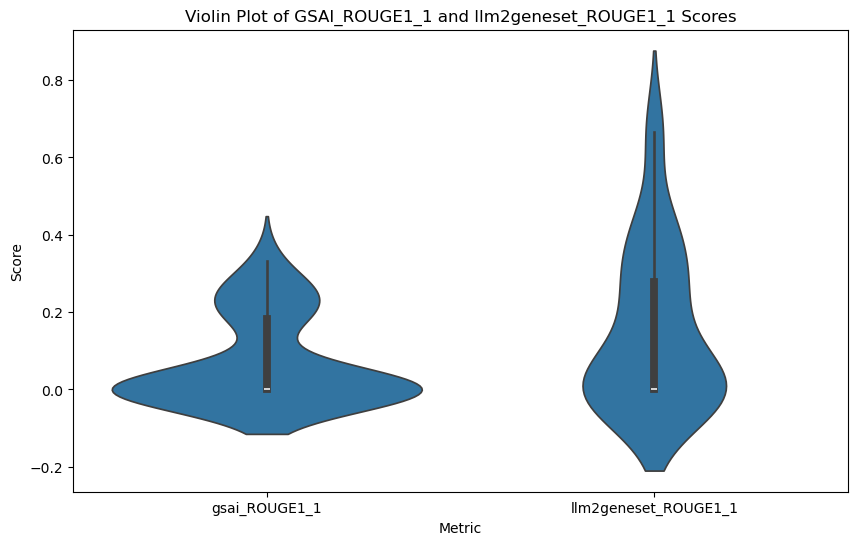

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


# Reshape the DataFrame to long format
df_long = pd.melt(df_output, id_vars=['gt_name_1'], value_vars=['gsai_ROUGE1_1', 'llm2geneset_ROUGE1_1'],
                  var_name='Metric', value_name='Score')

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Metric', y='Score', data=df_long)
plt.title('Violin Plot of GSAI_ROUGE1_1 and llm2geneset_ROUGE1_1 Scores')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.show()

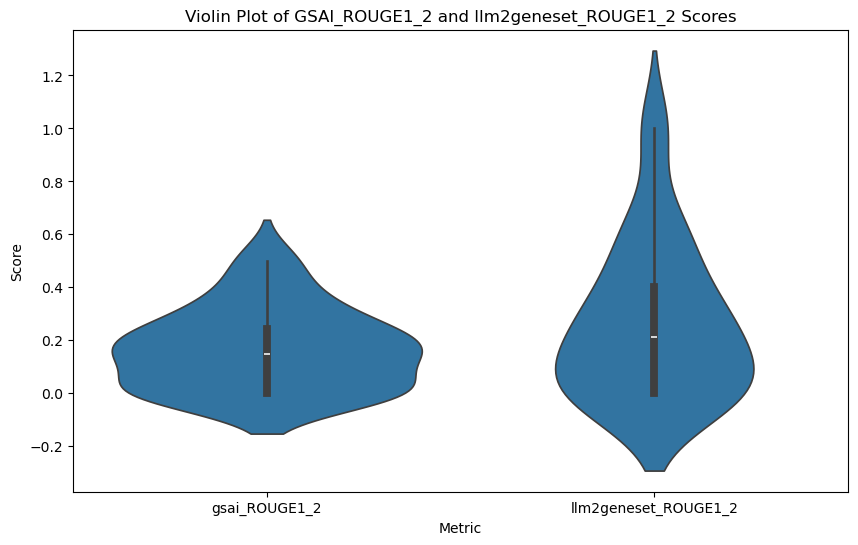

In [13]:
# Reshape the DataFrame to long format
df_long = pd.melt(df_output, id_vars=['gt_name_2'], value_vars=['gsai_ROUGE1_2', 'llm2geneset_ROUGE1_2'],
                  var_name='Metric', value_name='Score')

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Metric', y='Score', data=df_long)
plt.title('Violin Plot of GSAI_ROUGE1_2 and llm2geneset_ROUGE1_2 Scores')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.show()